# EDA

In [4]:
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature.peak import peak_local_max
import hashlib
import re

plt.rcParams["figure.figsize"] = (20, 8)

In [7]:
filename = "../data/songs/Mood (feat. Iann Dior).wav"

In [8]:
signal, sample_rate = librosa.load(filename, sr=44100, duration=20)

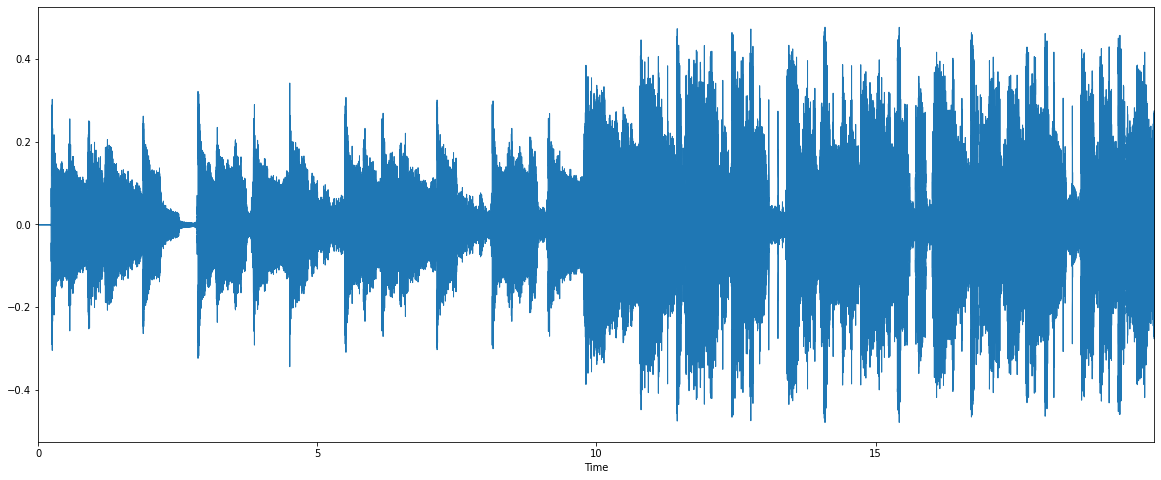

In [9]:
# plot the first 10 secs of a song
librosa.display.waveplot(signal, sr=sample_rate, max_points=50000.0, x_axis="time", offset = 0.0)

## Signal Processing

With librosa, we can easily plot the spectrogram of a signal

### Spectrogram example

We compute a Short Time Fourier Transform, followed by a Log transform to focus on the frequencies of the frame.

/Users/nohossat/Documents/simplon_projets/sezame/venv/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/nohossat/Documents/simplon_projets/sezame/venv/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/nohossat/Documents/simplon_projets/sezame/venv/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


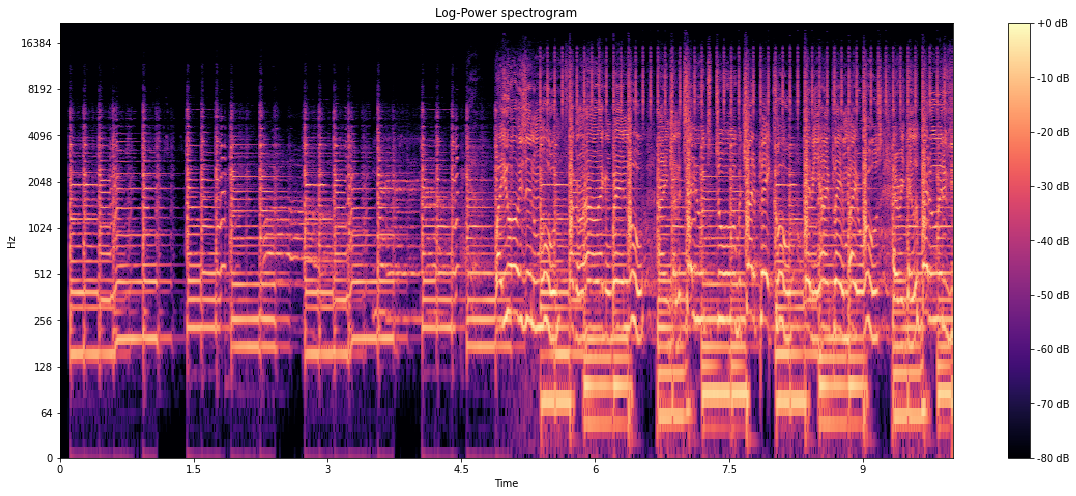

In [10]:
signal = np.abs(librosa.stft(signal, n_fft=4096, window='hann')) # we will analyze 100ms frame

signal_db = librosa.power_to_db(signal**2, ref=np.max)
librosa.display.specshow(signal_db, sr=sample_rate, x_axis="time", y_axis="log")
plt.title('Log-Power spectrogram')
plt.colorbar(format="%+2.0f dB")

The vertical axis shows frequencies (from 0 to 10kHz), and the horizontal axis shows the time of the clip. Since we see that all action is taking place at the bottom of the spectrum, we can convert the frequency axis to a logarithmic one.

### Compute Spectrogram peaks

We want to get the peaks from each spectrogram and plot them to see that they are correct. Since I have to play with the axis and I want to go on with the hashing, we will see this later.

In [11]:
peaks = peak_local_max(signal_db, min_distance=30)
freq_coors = [i for i, j in peaks]
time_coors = [j for i, j in peaks]

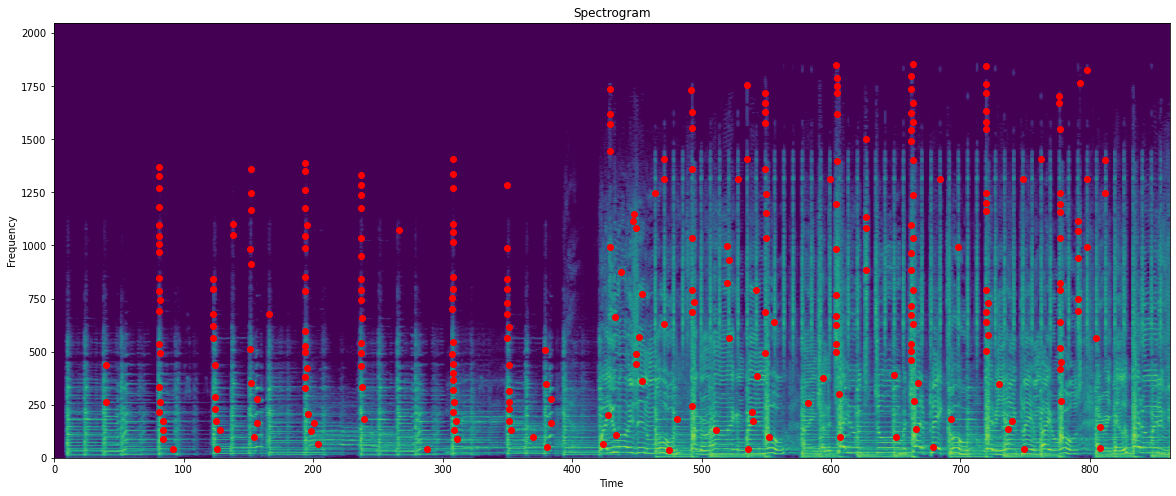

In [12]:
fig, ax = plt.subplots(figsize=(20,8))

ax.imshow(signal_db, aspect='auto')
ax.scatter(time_coors, freq_coors, color="red")
ax.set_xlabel('Time')
ax.set_ylabel('Frequency')
ax.set_title("Spectrogram")
plt.gca().invert_yaxis()
plt.show()

### Fingerprinting

we will link the peaks between each other depending on the degree of connection (how many peaks are linked together) and the time separating each peak. This combination will form the fingerprint of one frame

Check the fingerprinting.py file to see the complete code

In [13]:
# get samples
signal, sample_rate = librosa.load(filename, sr=44100, duration=30)

In [14]:
def generate_fingerprints(samples, min_dist=20, fan_value=20, n_fft=4096, is_dict=False, plot=False):
    """
    Create the spectrogram of song, compute the highest peaks, create the fingerprints and hash them before storage

    Parameters
    ==============
    samples : the sample of the song
    min_dist : the minimum distance in pixels between 2 peaks
    fan_value : how many peaks can be connected to one
    n_fft : value used for the STFT
    is_dict : if indicates if a dictionary with hash as key must be returned

    Output
    ==============
    Returns the hashed fingerprints
    """

    # transform data from time-domain to frequency domain
    signal = np.abs(librosa.stft(samples, n_fft=n_fft))
    
    # get spectrograms
    signal_db = librosa.power_to_db(signal**2, ref=np.max)
    
    # get spectrograms peaks
    peaks = peak_local_max(signal_db, min_distance=min_dist)
    
    # plot 
    if plot:
        freq_coors = [i for i, j in peaks]
        time_coors = [j for i, j in peaks]
        fig, ax = plt.subplots(figsize=(20,8))
        ax.imshow(signal_db, aspect='auto')
        ax.scatter(time_coors, freq_coors, color="red")
        ax.set_xlabel('Time')
        ax.set_ylabel('Frequency')
        ax.set_title("Spectrogram")
        plt.gca().invert_yaxis()
        plt.show()
    
    # extract fingerprints and create hashes
    idx_freq = 0
    idx_time = 1
    
    # the fingerprints must have a minimum time distance to be linked
    MIN_HASH_TIME_DELTA = 10
    MAX_HASH_TIME_DELTA = 200
    
    # the hash can be pretty long so we will only keep the first 30 characters
    FINGERPRINT_REDUCTION = 30
    
    if is_dict :
        hashes = {}
    else : 
        hashes = []
    
    for i in range(len(peaks)):
        for j in range(1, fan_value): 
            if (i + j) < len(peaks):
                freq1 = peaks[i][idx_freq]
                freq2 = peaks[i + j][idx_freq]
                t1 = peaks[i][idx_time]
                t2 = peaks[i + j][idx_time]
                t_delta = t2 - t1
            
                if MIN_HASH_TIME_DELTA <= t_delta <= MAX_HASH_TIME_DELTA:
                    h = hashlib.sha1(f"{str(freq1)}|{str(freq2)}|{str(t_delta)}".encode('utf-8'))
                    if is_dict :
                        hashes[h.hexdigest()[0:FINGERPRINT_REDUCTION]] = int(t1) # {hash : time_offset}
                    else : 
                        hashes.append((h.hexdigest()[0:FINGERPRINT_REDUCTION], int(t1))) # (hash, time_offset)
    
    return set(hashes)

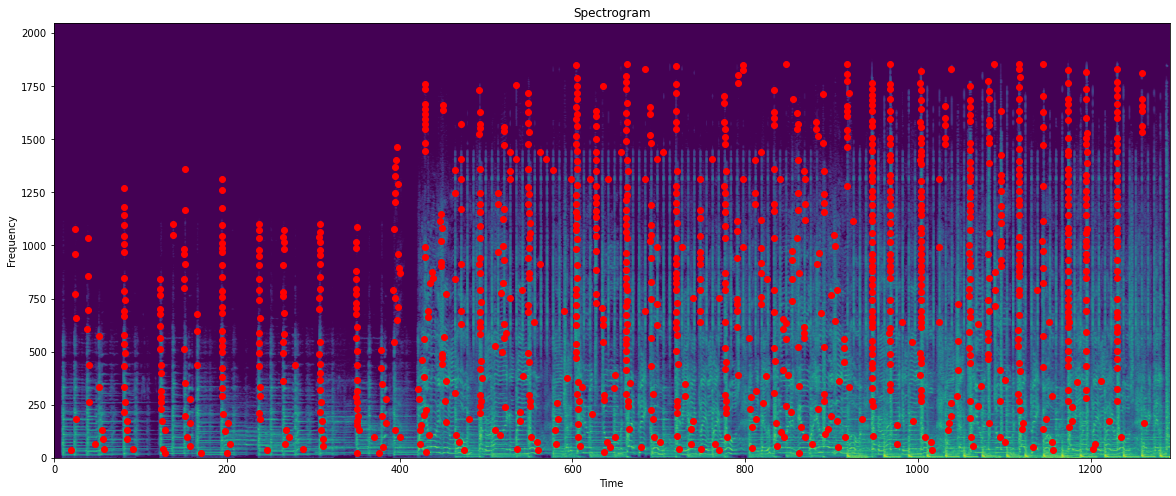

3672

In [15]:
hashes = generate_fingerprints(signal, plot=True)
len(hashes)